In [1]:
%matplotlib inline
import sys
sys.path.append("../")

import cv2
#from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab
import numpy as np
import scipy.io as scio

from PIL import Image

import quat_math as qm
from object_pose_utils.utils import to_np, to_var

import warnings; warnings.simplefilter('ignore')
pylab.rcParams['figure.figsize'] = 20, 12

import os
import sys
module_path = os.path.abspath(os.path.join('tools'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('lib'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
def imshowCV(img, axis = False, show = True):
    if not axis:
        plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if(show):
        plt.show()
    
def imshow(img, axis = False, colorbar = False, show = True):
    if not axis:
        plt.axis('off')
    plt.imshow(img)
    if(colorbar):
        plt.colorbar()
    if(show):
        plt.show()

In [3]:
from featurization import PoseCNNFeaturizer

featurizer = PoseCNNFeaturizer()

Tensor("fifo_queue_Dequeue:0", dtype=float32)
Tensor("conv5_3/conv5_3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("conv4_3/conv4_3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("score_conv4/score_conv4:0", shape=(?, ?, ?, 64), dtype=float32)
Tensor("upscore_conv5_1:0", shape=(?, ?, ?, 64), dtype=float32)
Tensor("upscore_1:0", shape=(?, ?, ?, 64), dtype=float32)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Tensor("score/score:0", shape=(?, ?, ?, 22), dtype=float32)
Tensor("div:0", shape=(?, ?, ?, 22), dtype=float32)
Tensor("fifo_queue_Dequeue:1", dtype=int32)
Tensor("conv5_3/conv5_3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("conv4_3/conv4_3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("score_conv4_vertex/BiasAdd:0", shape=(?, ?, ?, 128), dtype=float32)
Tensor("upscore_conv5_vertex_1:0", shape=(?, ?, ?, 128), dtype=float32)
Tensor("ToInt32:0", shape=(?, ?, ?), dtype=int32)


In [79]:
from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.image_processing import ImageNormalizer

dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'
object_list = list(range(1,22))
mode = "test"

output_format = [otypes.IMAGE, 
                 otypes.DEPTH_IMAGE]

dataset = YCBDataset(dataset_root, mode=mode, 
                     object_list = object_list, 
                     output_data = output_format, 
                     #preprocessors = [InplaneRotator],
                     #postprocessors = [ImageNormalizer()],
                     image_size = [640, 480], num_points=1000)

#dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)

In [80]:
print(len(dataset))
_, u_idxs = np.unique(zip(*dataset.image_list)[0], return_index = True)
dataset.image_list = np.array(dataset.image_list)[u_idxs].tolist()
dataset.list_obj = np.array(dataset.list_obj)[u_idxs].tolist()
print(len(dataset))


14025
2949


In [51]:
7, 10,
dataset.classes[21]

'061_foam_brick'

In [81]:
for j in range(len(dataset)):
    path = dataset.getPath(j)
    if(path == '0052/000526'):
        print(j, path)

(1078, '0052/000526')


In [82]:
from featurization import PoseCNNDataset
pcnn_dataset = PoseCNNDataset(dataset)
im, depth, meta_data = pcnn_dataset[1078]

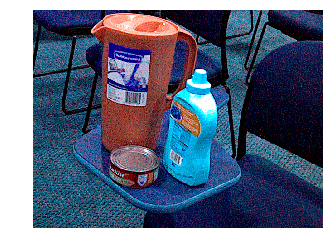

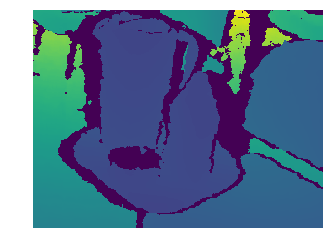

array([[[ 0.85525545, -0.58749533,  0.86787053],
        [ 0.50085668, -0.80106274,  0.48189534],
        [ 0.13296826,  0.11466343,  0.12073969],
        [ 0.02981819, -0.06587408, -0.04820062]],

       [[ 0.30509603, -0.39032227,  0.29881257],
        [-0.27926859,  0.1563896 , -0.31219862],
        [-0.9104535 , -0.90729808, -0.90179968],
        [ 0.01843756,  0.07263976, -0.08132385]],

       [[-0.41887254,  0.70887157, -0.39687879],
        [ 0.81923882, -0.57778944,  0.81872439],
        [-0.39165558, -0.40455052, -0.4149441 ],
        [ 0.80719808,  0.80404425,  0.84940988]]])

In [83]:
imshow(im) 
imshow(depth)
meta_data['poses']

In [85]:
from quat_math import quaternion_from_matrix

meta_idx = np.where(meta_data['cls_indexes'].flatten()==5)[0][0]
target_r = meta_data['poses'][:, :, meta_idx][:, 0:3]
target_t = np.array([meta_data['poses'][:, :, meta_idx][:, 3:4].flatten()])

transform_mat = np.identity(4)
transform_mat[:3, :3] = target_r
transform_mat[:3, 3] = target_t
quaternion_from_matrix(transform_mat)



array([ 0.79469826,  0.25354042, -0.08994123,  0.54413493])

In [34]:
seg = featurizer(im, depth, meta_data)

[2, 0, 1]
[[ 0.000000e+00  1.100000e+01  1.188000e+02 -2.000002e-01  3.872000e+02
   2.902000e+02  4.247000e+03]
 [ 0.000000e+00  5.000000e+00  2.823000e+02  1.599000e+02  4.297000e+02
   3.601000e+02  1.946000e+03]
 [ 0.000000e+00  6.000000e+00  1.569000e+02  2.690000e+02  2.911000e+02
   4.010000e+02  9.390000e+02]]


In [30]:
np.array(dataset.classes)[seg['rois'][:,1].astype(int)]

array(['019_pitcher_base', '006_mustard_bottle', '007_tuna_fish_can'],
      dtype='|S21')

In [36]:
pose_idx = np.nonzero(seg['rois'][:,1] == 9)[0]
pose_idx

array([], dtype=int64)

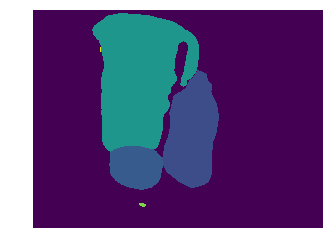

In [10]:
for data in dataset(imshow(seg['labels'])

In [90]:
from fcn.config import cfg
from fcn.test import _get_image_blob

#blob = _get_image_blob(im, depth, meta_data)
cfg

{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'BACKGROUND': '',
 'CAD': '',
 'EPS': 1e-14,
 'EXP_DIR': 'default',
 'FEATURE_STRIDE': 16,
 'FLIP_X': False,
 'GPU_ID': 0,
 'INPUT': 'RGBD',
 'NETWORK': 'VGG16',
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POSE': '',
 'RIG': '',
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/bokorn/src/posecnn_thecat/PoseCNN',
 'TEST': {'BBOX_REG': True,
  'GAN': False,
  'GRID_SIZE': 256,
  'NMS': 0.3,
  'POSE_REFINE': False,
  'POSE_REG': False,
  'RANSAC': False,
  'RPN_NMS_THRESH': 0.7,
  'RPN_POST_NMS_TOP_N': 300,
  'RPN_PRE_NMS_TOP_N': 6000,
  'SCALES_BASE': [0.25, 0.5, 1.0, 2.0, 3.0],
  'SEGMENTATION': True,
  'SINGLE_FRAME': False,
  'SYNTHETIC': False,
  'VERTEX_REG_2D': False,
  'VERTEX_REG_3D': False,
  'VISUALIZE': False,
  'VOTING_THRESHOLD': -1},
 'TRAIN': {'ADAPT': False,
  'ADAPT_NUM': 400,
  'ADAPT_RATIO': 1,
  'ADAPT_ROOT': '',
  'ADAPT_WEIGHT': 0.1,
  'ADD_NOISE': False,
  'BATCH_SIZE': 128,
  'BBOX_INSIDE_WEIGHTS':